# Machine Learning for Finance Final Project
## Member (equal contribution): Yuqiang Zhu (yz4424), Junjie Lyu(jl6287), Yang Zhou(yz4347)

# Problem 1
We decide to use three types of models ,which are Convoluted Neural Network, Xgboost, Lasso, to generate combinations of given factors.

Train set period: 2007-2009
Test set period: 2010

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset

import torch.nn.functional as F
from torch.utils.data.dataset import Dataset,Subset
from random import choice
import pickle
import bz2
import dill
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import gc
from warnings import simplefilter
import warnings
warnings.filterwarnings('ignore')
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# prep functions

In [3]:
def sort_cols(test):
    return (test.reindex(sorted(test.columns), axis=1))

model_dir = r'D:\\data\\pd_frame\\'


# factor names
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
       'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG', 'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
       'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
       'DIVFIN', 'DIVYILD', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
       'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET',
        'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
       'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP', 'PAPER', 'PHARMA',
       'PRECMTLS','PSNLPROD','REALEST',
       'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE', 'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR',
       'TELECOM', 'TRADECO', 'TRANSPRT', 'WIRELESS']

style_factors = ['BETA','SIZE','MOMENTUM','VALUE']

def get_formula(alpha):
    L = ["0", alpha]
    L.extend(style_factors)
    L.extend(industry_factors)
    return "Ret ~ " + " + ".join(L)


def wins(x, a, b):
    return (np.where(x <= a, a, np.where(x >= b, b, x)))


def clean_nas(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

    for numeric_column in numeric_columns:
        df[numeric_column] = np.nan_to_num(df[numeric_column])

    return df

def estimate_factor_return(factor_name_list:str,factor_df:pd.DataFrame,output = 'ret'):
    factor_df = clean_nas(factor_df)
    liquid_universe_df = factor_df.where(factor_df['IssuerMarketCap']>1e9).dropna(axis=0)
    res_list = []

    # winsoried for ret
    ret_series = liquid_universe_df.loc[:, 'Ret']
    up_q_float = ret_series.quantile(0.95)
    down_q_float = ret_series.quantile(0.05)
    liquid_universe_df.loc[:, 'Ret'] = wins(ret_series, down_q_float, up_q_float)
    for factor_name in factor_name_list:
        #winsorized
            #factor
        factor_series = liquid_universe_df.loc[:,factor_name]
        up_q_float = factor_series.quantile(0.95)
        down_q_float = factor_series.quantile(0.05)
        liquid_universe_df.loc[:, factor_name] = wins(factor_series,down_q_float,up_q_float)

        #get reg formula
        formula_str = get_formula(factor_name)
        #OLS regression
        try:
            model = smf.ols(formula = formula_str,data = liquid_universe_df)
        except:
            print('error')
        res = model.fit()
        res_list.append(res)
    if output=='ret':
        ret_list = [res_list[i].params[factor_name_list[i]] for i in range(len(res_list))]
        return ret_list
    return res_list

def factor_ret(factor_name_list:list,frames:dict,new_factor_df):
    ret_list = []
    date_list = []
    id = list(set(new_factor_df['ID'].tolist()))
    idx = 0
    for key,factor_df in frames.items():
        idx += 1
        if idx<=4:
            continue
        factor_df.set_index('ID',inplace=True)
        factor_df = factor_df.reindex(id)
        date = pd.to_datetime(key)
        new_factor_sub_df = new_factor_df.where(new_factor_df['date'] == date).dropna(axis=0)
        new_factor_sub_df.set_index('ID',inplace=True)
        new_factor_sub_df = new_factor_sub_df.loc[:,factor_name_list]
        if new_factor_sub_df.shape[0]==0:
            continue
        factor_df = pd.merge(factor_df,new_factor_sub_df,left_index=True,right_index=True)
        res = estimate_factor_return(factor_name_list,factor_df,output='ret')
        ret_list.append(res)
        date_list.append(key)

    ret_df = pd.DataFrame(index=date_list,data=ret_list,columns = factor_name_list)
    return ret_df
# standlized the combined factor in order to make them comparable in factor return.
def standlizard(factor_df):
    factor_name_str = factor_df.columns.tolist()[-1]
    factor_pivot_df = factor_df.pivot_table(index = 'date',columns = 'ID',values = factor_name_str)
    factor_demean_pivot_df = factor_pivot_df.sub(factor_pivot_df.mean(axis = 1),axis =0)
    factor_demean_pivot_df = factor_demean_pivot_df.divide(factor_pivot_df.std(axis=1),axis =0)
    factor_stack_df = factor_demean_pivot_df.stack().reset_index()
    factor_stack_df.columns = factor_df.columns.tolist()
    return factor_stack_df

def cum_ror(factor_df,factor_name_str,beg_y_int,end_y_int,title_str):
    factor_ret_df = pd.DataFrame()
    factor_df['date'] = pd.to_datetime(factor_df['date'])
    factor_list = [factor_name_str]
    for year in list(range(beg_y_int,end_y_int+1)):
        frames = {}
        fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
        frames.update(pickle.load(bz2.open(fil, "rb")))

        for x in frames:
            frames[x] = sort_cols(frames[x])

        ret_df = factor_ret(factor_list,frames,factor_df)
        if factor_ret_df.empty:
            factor_ret_df = ret_df
        else:
            factor_ret_df = pd.concat([factor_ret_df,ret_df],axis=0)
        del frames

    factor_ret_df.index = pd.to_datetime(factor_ret_df.index,format = '%Y%m%d')
    factor_ret_df.cumsum().plot(figsize=(10,5))
    plt.legend()
    plt.title(title_str)
    plt.show()



### Neural NetWork Model

In [ ]:
#CNN
# one channel
batch_size = 64


#randomly split dataset into two part
def dataset_split(test_per_float,obj_dataset):
    size_int = len(obj_dataset)
    test_size_int = int(test_per_float*size_int)
    train_size_int = size_int-test_size_int
    train_dataset,test_dataset = torch.utils.data.random_split(obj_dataset,[train_size_int,test_size_int])
    return train_dataset,test_dataset

### Network Structure

In [ ]:
class inception(nn.Module):
    def __init__(self,in_channel_int):
        super(inception, self).__init__()
        self.avg_pool_1x1 = nn.Sequential(
            nn.AvgPool2d(3,padding=1,stride=1),
            nn.Conv2d(in_channel_int,24,kernel_size=(1,1))
        )
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(in_channel_int,16,kernel_size=(1,1))
        )
        self.conv_1x1_5x5 = nn.Sequential(
            nn.Conv2d(in_channel_int,16,kernel_size=(1,1)),
            nn.Conv2d(16,24,kernel_size=(5,5),padding=2)
        )
        self.conv_1x1_3x3_3x3 = nn.Sequential(
            nn.Conv2d(in_channel_int, 16, kernel_size=(1, 1)),
            nn.Conv2d(16, 24, kernel_size=(3, 3),padding=1),
            nn.Conv2d(24,24,kernel_size=(3,3),padding=1)
        )
    def forward(self, x):
        x_avg_pool_1x1 = self.avg_pool_1x1(x)
        x_conv_1x1 = self.conv_1x1(x)
        x_conv_1x1_5x5 = self.conv_1x1_5x5(x)
        x_conv_1x1_3x3_3x3 = self.conv_1x1_3x3_3x3(x)
        x = torch.cat([x_avg_pool_1x1,x_conv_1x1,x_conv_1x1_5x5,x_conv_1x1_3x3_3x3],dim=1)
        return x

class resid_net(nn.Module):
    def __init__(self,in_channel_int,out_channel_int):
        super(resid_net,self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channel_int,out_channel_int,kernel_size=(3,3),padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channel_int, out_channel_int, kernel_size=(3, 3), padding=1),
            nn.ReLU()
        )
    def forward(self,x):
        conv = self.conv_layer(x)
        return F.relu(conv+x)

class CNN_module(nn.Module):
    def __init__(self,in_channel,out_size):
        super(CNN_module, self).__init__()
        self.sequential_cnn = nn.Sequential(
            nn.Conv2d(in_channel,64,kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2),
            inception(64),
            nn.Dropout(0.2),
            resid_net(88,88),
            nn.BatchNorm2d(88),
            nn.Conv2d(88,88,kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(2),
            inception(88),
            nn.Dropout(0.2),
            resid_net(88,88),
            #nn.Conv2d(88,88,kernel_size=(3,3)),
            nn.Flatten(),
            nn.Linear(32384,out_size)
        )

    def forward(self,x):
        pred = self.sequential_cnn(x)
        return pred

### Dataset setting
We use data from 2007-2009 as training set and stack them to get samples with 5 channel(5 days data stacked together). The sample shape is [5,stock_amount,factor_amount]

In [ ]:
class factor_set(Dataset):
    def __init__(self,year = 2003,random = False,channel = 1,period = 3):
        if random:
            year = choice(list(range(2003,2009)))
        super().__init__()
        self.years = [year+i for i in range(period)]
        self.path_str = model_dir
        self.frames = {}
        for year in self.years:
            fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
            self.frames.update(pickle.load(bz2.open(fil, "rb")))
        self.label_list = []
        self.frames_list = []
        self.id_amt_int = 0
        #index intersection
        try:
            id = pd.read_csv('id.csv',index_col = 0)['id'].tolist()
        except:
            id = set(self.frames.popitem()[1]['ID'].to_list())
            for x in self.frames:
                frame = self.frames[x]
                frame = frame.where(frame['IssuerMarketCap'] > 1e9).dropna(axis=0,how = 'all')
                # get liquad universe
                id = id.intersection(set(frame['ID'].tolist()))
            id = list(id)
            pd.DataFrame(id,columns=['id']).to_csv('id.csv')

        self.id_amt_int = len(id)
        for x in self.frames:
            frame = self.frames[x].set_index('ID')
            self.label_list.append(frame.loc[id, ['Ret']])
            frame = sort_cols(frame.loc[id,['STREVRSL', 'LTREVRSL', 'EARNQLTY','EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']
                                                             +style_factors]).bfill().ffill()
            self.frames_list.append(torch.tensor(frame.values))
            del frame
        self.label_tensors_list = []
        self.stacked_list =[]
        #stack the data to get data with channel
        for x_i in range(channel-1,len(self.frames)):
            self.label_tensors_list.append(torch.LongTensor(self.label_list[x_i].values))
            self.stacked_list.append(torch.stack(self.frames_list[x_i+1-channel:x_i+1],dim = 0))

    def __getitem__(self, index):
        return self.label_tensors_list[index], self.stacked_list[index]

    def __len__(self):
        return len(self.label_tensors_list)



In [ ]:
def train_loop(train_datloader,model,loss_func,optimizer):
    print('--------------Train Begin--------------')
    model.train()
    size = len(train_datloader.dataset)
    idx = 0
    for index_int,(y,X) in enumerate(train_datloader):
        print(f'batch {index_int}')
        optimizer.zero_grad()
        pred = model(X.float())
        loss = loss_func(pred,y.float().squeeze())
        loss.backward()
        optimizer.step()
        if index_int%1==0:
            loss_float,current = loss.item(),idx+len(X)
            print(f"loss: {loss_float:>7f}  [{current:>5d}/{size:>5d}]")
            idx = current
            with torch.no_grad():
                global train_loss_list
                train_loss_list.append(loss_float)

def test_loop(test_datloader,model,loss_func):
    print('--------------Test Begin--------------')
    model.eval()
    size = len(test_datloader.dataset)
    idx = 0
    loss_list = []
    for index_int,(y,X) in enumerate(test_datloader):
        with torch.no_grad():
            pred = model(X.float())
            loss = loss_func(pred,y.float().squeeze())
            if index_int%1==0:
                loss_float,current = loss.item(),idx+len(X)
                print(f"loss: {loss_float:>7f}  [{current:>5d}/{size:>5d}]")
                idx = current
                loss_list.append(loss_float)
    with torch.no_grad():
        global test_loss_list
        test_loss_list += loss_list
        print(f'Average Test Loss: {np.mean(loss_list)}')

### K-Fold Cross Validation
Below are K-Fold Cross Validation functions to help determine the hyperparameter of the CNN.
Due to the complexity of CNN and the huge amount of time it need for training, we just ran a couple epochs of training to decide the appropriate learning rate for Adam optimizer.

In [ ]:
def train_loop_kfold(train_datloader,val_loader,model,loss_func,optimizer):
    print('--------------Train Begin--------------')
    model.train()
    size = len(train_datloader.dataset)
    idx = 0
    for index_int,(y,X) in enumerate(train_datloader):
        print(f'batch {index_int}')
        optimizer.zero_grad()
        pred = model(X.float())
        loss = loss_func(pred,y.float().squeeze())
        loss.backward()
        optimizer.step()
        if index_int%1==0:
            loss_float,current = loss.item(),idx+len(X)
            print(f"loss: {loss_float:>7f}  [{current:>5d}/{size:>5d}]")
            idx = current
    print("Validation Begin:\n")
    model.eval()
    loss_list = []
    for index_int,(y,X) in enumerate(val_loader):
        with torch.no_grad():
            pred = model(X.float())
            loss = loss_func(pred,y.float().squeeze())
            loss_list.append(loss.item())
    with torch.no_grad():
        print(f'Validation Loss:{np.mean(loss_list)}')
        return np.mean(loss_list)

def ksplit(dataset,k):
    dataset_len_int = len(dataset)
    sub_len_int = int(dataset_len_int/(k-1))
    idx_list = list(range(dataset_len_int))
    Kflod_list = []
    for i in range(k):
        Kflod_list.append(idx_list[sub_len_int*i:sub_len_int*(i+1)])
    return Kflod_list

### Training Process

In [ ]:
def train_proc(KFold):
    channel_int = 5
    out_size = factors.id_amt_int
    epochs = 50


    # loss func
    loss_func = nn.MSELoss()

    if KFold:
        #k-FOLD Validation part
        K = 5
        kFold_list = ksplit(train_dataset,K)
        # hyper-params
        lr_list = [1e-2, 1e-3, 1e-4]
        KFold_epoch_int = 1
        loss_list = []
        for k in range(K):
            idx_list = list(range(len(train_dataset)))
            train_sub_dataset = Subset(train_dataset,idx_list[idx_list not in kFold_list[k]]).dataset
            valid_dataset = Subset(train_dataset,kFold_list[k]).dataset
            train_loader = DataLoader(train_sub_dataset,batch_size=64)
            valid_loader =DataLoader(valid_dataset,batch_size=64)
            sub_loss_list =[]
            for lr in lr_list:
                model = CNN_module(channel_int, out_size)
                # optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                loss = 0
                for e in range(KFold_epoch_int):
                    loss += train_loop_kfold(train_loader,valid_loader,model,loss_func,optimizer)
                loss /= KFold_epoch_int
                sub_loss_list.append(loss)
            loss_list.append(sub_loss_list)
        loss_array = np.array(loss_list)
        loss_mean_array = np.mean(loss_array,axis = 0)
        min_loc_int = np.argmin(loss_mean_array)
        learning_rate = lr_list[min_loc_int]
    else:
        learning_rate =1e-4

    # optimizer
    model = CNN_module(channel_int, out_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True,drop_last=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    for t in range(epochs):
        print(f'epochs {t + 1}\n---------------------')
        train_loop(train_loader,model, loss_func, optimizer)
        test_loop(test_loader,model,loss_func)
    print('Done')
    torch.save(model.state_dict(),f'CNN_complete_Adam_50.pt')

Due to the huge amount of time it needs to train the CNN, we finish the training process early and save the trained model. We use the bool variable to indicate whether to train a new model or to use a trained model.

In [ ]:
train = False
if train:
    try:
        with open(r'D:\data\pd_frame\factors_set_2007-2009.pkl', 'rb') as f:
            factors = dill.load(f)
    except:
        factors = factor_set(2007, random=False, channel=5, period=3)
        # dump dataset
        with open(r'D:\data\pd_frame\factors_set_2007-2009.pkl', 'wb') as f:
            dill.dump(factors, f)
    train_dataset, test_dataset = dataset_split(0.1, factors)
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []
    train_proc(False)
    loss_df = pd.DataFrame(train_loss_list)
    df_len = len(train_loss_list)
    loss_df.loc[:,'val_loss'] = val_loss_list+[0]*(df_len-len(val_loss_list))
    loss_df.loc[:,'test_loss'] = test_loss_list+[0]*(df_len-len(test_loss_list))
    loss_df.to_csv('CNN_complete_Adam_50_loss.csv')
else:
    model = CNN_module(5,1478)
    model.load_state_dict(torch.load(f'CNN_complete_Adam_50.pt'))
    with open(r'D:\data\pd_frame\factors_set_2010.pkl', 'rb') as f:
        factors = dill.load(f)

    factor_sub = Subset(factors,list(range(504,752)))
    del factors
    factor_loader = DataLoader(factor_sub,batch_size=len(factor_sub.indices))
    for idx,(y,X) in enumerate(factor_loader):
        pred = model(X.float())
    pass


Cumulative Rate of Return plotting

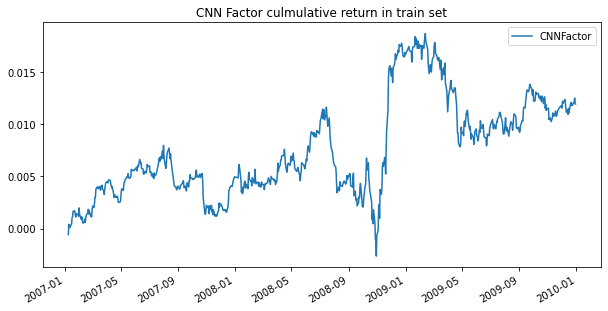

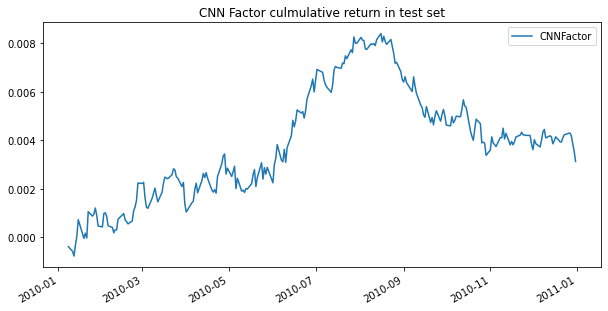

In [5]:
factor_train_df = pd.read_csv('CNNFactor_train.csv')
factor_train_df = standlizard(factor_train_df)
cum_ror(factor_train_df,'CNNFactor',2007,2009,'CNN Factor culmulative return in train set')
factor_test_df = pd.read_csv('CNNFactor_test.csv')
factor_test_df = standlizard(factor_test_df)
cum_ror(factor_test_df,'CNNFactor',2010,2010,'CNN Factor culmulative return in test set')

### Lasso Model

#### Data Preparation

In [ ]:
class factor_set_lasso(Dataset):
    def __init__(self,year = 2003,random = False,channel = 1,period = 3):
        if random:
            year = choice(list(range(2003,2009)))
        super().__init__()
        self.years = [year+i for i in range(period)]
        self.path_str = model_dir
        self.frames = {}
        for year in self.years:
            fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
            self.frames.update(pickle.load(bz2.open(fil, "rb")))
        self.label_list = []
        self.frames_list = []
        self.id_amt_int = 0
        #index intersection
        try:
            id = pd.read_csv('id.csv',index_col = 0)['id'].tolist()
        except:
            id = set(self.frames.popitem()[1]['ID'].to_list())
            for x in self.frames:
                frame = self.frames[x]
                frame = frame.where(frame['IssuerMarketCap'] > 1e9).dropna(axis=0,how = 'all')
                # get liquad universe
                id = id.intersection(set(frame['ID'].tolist()))
            id = list(id)
            pd.DataFrame(id,columns=['id']).to_csv('id.csv')

        self.id_amt_int = len(id)
        for x in self.frames:
            frame = self.frames[x].set_index('ID')
            self.label_list.append(frame.loc[id, ['Ret']])
            frame = sort_cols(frame.loc[id,['STREVRSL', 'LTREVRSL', 'EARNQLTY','EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']]).bfill().ffill()
            self.frames_list.append(frame)
            del frame

    def __getitem__(self, index):
        return self.label_list[index], self.frames_list[index]

    def __len__(self):
        return len(self.label_list)

#train set
factor_lasso_train = factor_set_lasso(2007,period=3)
with open(r'D:\data\pd_frame\factors_set_lasso_2007-2009.pkl', 'wb') as f:
    dill.dump(factor_lasso_train,f)

#test set
factor_lasso_test = factor_set_lasso(2010,period=1)
with open(r'D:\data\pd_frame\factors_set_lasso_2007-2009.pkl', 'wb') as f:
    dill.dump(factor_lasso_test,f)

In [ ]:
#training
with open(r'D:\data\pd_frame\factors_set_lasso_2007-2009.pkl', 'rb') as f:
    factor = dill.load(f)
X = pd.concat(factor.frames_list,axis = 0)
y = pd.concat(factor.label_list,axis = 0)
reg = LassoCV(cv = 10,random_state=0).fit(X.values,y.values.reshape(-1))
#save the trained model
with open(r'C:\Users\zhuyu\PycharmProjects\ml4fin\LassoCV10.pt','wb') as f:
    dill.dump(reg,f)

In [ ]:
id_len = len(factor.label_list)
# train set prediction
train_pred = reg.predict(X)
train_pred_df = pd.DataFrame(train_pred,index = X.index,columns=["LassoFactor"])
date = []
for i in factor.frames.keys():
    date += [pd.to_datetime(i,format = '%Y%m%d')]*id_len
train_pred_df.reset_index(inplace=True)
train_pred_df.loc[:,"date"] = date
train_pred_df = train_pred_df.loc[:,['date','ID','LassoFactor']]
train_pred_df.to_csv('Lasso_factor_train.csv')

#test set prediction
with open(r'D:\data\pd_frame\factors_set_lasso_2010.pkl', 'rb') as f:
    factor = dill.load(f)
X_test = pd.concat(factor.frames_list,axis = 0)
test_pred = reg.predict(X_test.values)

test_pred_df = pd.DataFrame(test_pred,index = X_test.index,columns=["LassoFactor"])
date = []
for i in factor.frames.keys():
    date += [pd.to_datetime(i,format = '%Y%m%d')]*id_len
test_pred_df.reset_index(inplace=True)
test_pred_df.loc[:,"date"] = date
test_pred_df = test_pred_df.loc[:,['date','ID','LassoFactor']]
test_pred_df.to_csv('Lasso_factor_test.csv')

#### Cumulative rate of return

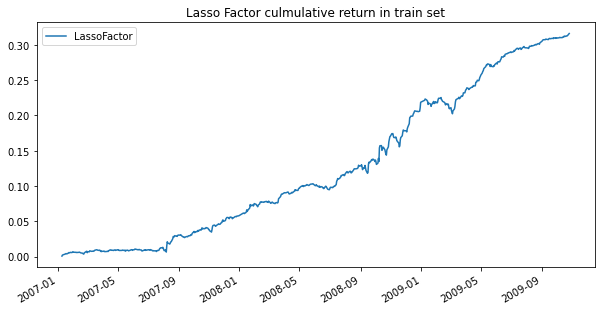

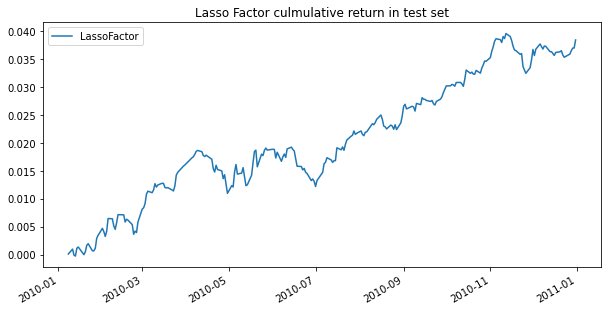

In [71]:
factor_train_df = pd.read_csv('Lasso_factor_train.csv')
factor_train_df = standlizard(factor_train_df)
cum_ror(factor_train_df,'LassoFactor',2007,2009,'Lasso Factor culmulative return in train set')
factor_test_df = pd.read_csv('Lasso_factor_test.csv')
factor_test_df = standlizard(factor_test_df)
cum_ror(factor_test_df,'LassoFactor',2010,2010,'Lasso Factor culmulative return in test set')

### Xgboost

In [7]:
def get_data(year):
    frames={}
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pickle.load( bz2.open( fil, "rb" ) ))
    df_list=[]
    for key,value in frames.items():
        dff=value[value.IssuerMarketCap>1e9].copy(deep=True)
        dff['date']=key
        df_list.append(dff)
    df=pd.concat(df_list)
    df=df[['ID','date','Ret','STREVRSL', 'LTREVRSL', 'EARNQLTY','EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']]
    df['Ret']=wins(df['Ret'], -0.25, 0.25)
    return df

In [8]:
train_data=get_data(2009)
y,X=train_data['Ret'].copy(),train_data[['STREVRSL', 'LTREVRSL', 'EARNQLTY','EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']].copy()

In [ ]:
#cross validation and training
from sklearn.model_selection import GridSearchCV
params=dict(gamma=[0.005, 0.01, 0.02],n_estimators=[50,100],max_depth=[8,10,12],learning_rate=[0.005,0.01,0.05],random_state=[42])
model=GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror',silent=1),params,n_jobs=5,cv=3)
model.fit(X,y)

print(f'Best params: {model.best_params_}')
print(f'Best validation score = {model.best_score_}')
model.cv_results_

In [ ]:
plot_importance(model.best_estimator_)

In [ ]:
final_model=model.best_estimator_

In [ ]:
# save model
with open(model_dir+'xgboost.pkl','wb') as f:
    pickle.dump(final_model,f)

In [ ]:
y_pred= final_model.predict(X)
train_data['XGBoost_Factor']=y_pred
train_data[['date','ID','XGBoost_Factor']].to_csv(model_dir+'XGBoostFactor_train.csv')

test_data=get_data(2010)
y_test,X_test=test_data['Ret'].copy(),test_data[['STREVRSL', 'LTREVRSL', 'EARNQLTY','EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']].copy()

y_pred1= final_model.predict(X_test)
test_data['XGBoost_Factor']=y_pred1
test_data[['date','ID','XGBoost_Factor']].to_csv(model_dir+'XGBoostFactor_test.csv')

#### Cumulative rate of return

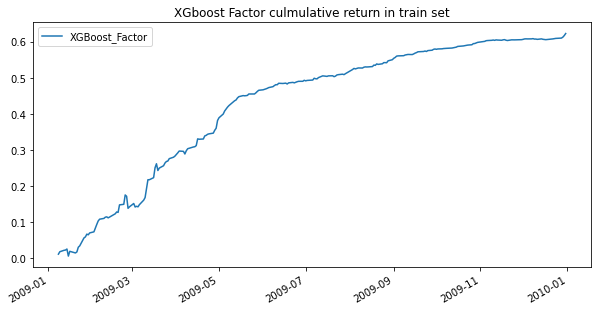

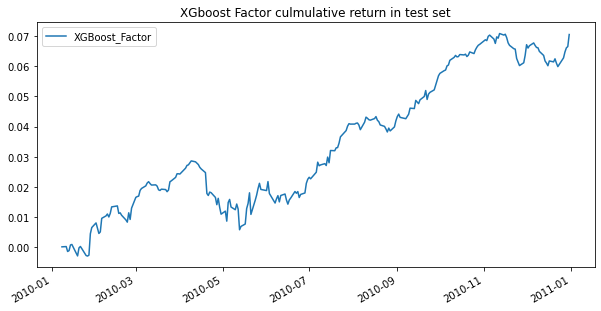

In [69]:
factor_train_df = pd.read_csv('XGBoostFactor_train.csv')
factor_train_df = standlizard(factor_train_df)
cum_ror(factor_train_df,'XGBoost_Factor',2009,2009,'XGboost Factor culmulative return in train set')
factor_test_df = pd.read_csv('XGBoostFactor_test.csv')
factor_test_df = standlizard(factor_test_df)
cum_ror(factor_test_df,'XGBoost_Factor',2010,2010,'XGboost Factor culmulative return in test set')

# Problem 2

In [ ]:
def estimate_uf(df,y):
    ## winsorize returns for fitting
    df[y] = wins(df[y], -0.25, 0.25)
    form = get_formula([],y)
    model = ols(form, data=df)
    results = model.fit()
    return results.params.values.reshape(-1,1)

def pseudoinverse(X):
    U,D,VT=np.linalg.svd(X)
    D_plus = np.zeros((X.shape[0], X.shape[1])).T
    D_=D[D!=0]
    n=len(D_)
    D_plus[:n, :n] = np.linalg.inv(np.diag(D_))
    X_plus = VT.T.dot(D_plus).dot(U.T)
    return X_plus

def optimization(my_date,k,alpha,alpha_name):
    try:
        estu=frames[my_date]
    except:
        print(my_date+' no data')
        return

    estu=pd.merge(estu,alpha, on = 'ID',how='inner')
    uf= estimate_uf(estu,alpha_name)

    rske = risk_exposures(estu)
    F = diagonal_factor_cov(my_date, rske)
    X = np.asarray(rske)
    D = np.asarray( (estu['SpecRisk'] / (100 * math.sqrt(252))) ** 2 )

    D_ = np.diag(1/D)
    D_X=np.matmul(D_,X)

    tmp=np.linalg.inv(F+pseudoinverse(np.matmul(X.T,D_X)))
    xx=1/k*np.matmul(tmp,uf)
    DD=np.diag(D**(-1/2))
    hh=np.matmul(np.matmul(DD,pseudoinverse(np.matmul(X.T,DD))),xx)
    return hh

# Problem 3

We get optimized weights from the function in Problem 2 and do backtest by holding each portfolio for 20 trade days (one month), considering no transaction cost or tax.

PS: Weights given from Problem 2 are not standardized which means their sum may not equal to one on each direction or zero. Some weights are far larger than 1. Therefore, to do the backtest, we need to standarized the weights. We try to keep the relative magnitude differences among different weights both Long and Short position. Our solution is to divide each weight on a cross section by the cross section's sum of absolute weights, which means we don't take account of any possible leverage.

#### Get Weights

In [ ]:
def get_weight(alpha,label,freq,k):
    model_dir = r'C:\Users\zhuyu\PycharmProjects\ml4fin\'
    df=pd.read_csv(model_dir+alpha+'_'+label+'.csv')

    mdf=df.set_index(['date','ID'])
    mdf=mdf.unstack().rolling(freq).mean().stack()
    mdf.columns=[alpha+'_mean']
    df=pd.merge(df,mdf,on=['date','ID'],how='inner')

    my_dates=np.unique(df.date.values)[::freq]

    df_list=[]
    for date in my_dates:
        dff=df[df.date==date]
        dff=dff.loc[(dff[alpha]>=dff[alpha].quantile(0.9))|(dff[alpha]<=dff[alpha].quantile(0.1))]
        #my_date=''.join([i.zfill(2) for i in date.split('/')])
        my_date=str(date)
        dff['weight_'+str(freq)]=optimization(my_date,k,dff,alpha)
        dff['weight_mean_'+str(freq)]=optimization(my_date,k,dff,alpha+'_mean')
        df_list.append(dff)

    result=pd.concat(df_list)
    return result

In [ ]:
result=get_weight('CNNFactor','train',20,0.25)
result.to_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\CNN_Factor_train_top.csv')
result=get_weight('CNNFactor','test',20,0.25)
result.to_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\CNN_Factor_train_top.csv')
result=get_weight('LassoFactor','train',20,0.25)
result.to_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\Lasso_Factor_train_top.csv')
result=get_weight('LassoFactor','test',20,0.25)
result.to_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\Lasso_Factor_train_top.csv')
result=get_weight('XGBoostFactor','train',20,0.25)
result.to_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\XGBoostFactor_train_top.csv')
result=get_weight('XGBoostFactor','test',20,0.25)
result.to_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\XGBoostFactor_train_top.csv')

In [ ]:
#Load return
with open(r'D:\data\pd_frame\ret_2007-2010.pkl','rb') as f:
    [date_list,ret_list] = dill.load(f)
date_list = pd.to_datetime(date_list)

In [5]:
#portfolio backtest
def bkt(weight_df, holding_period,title_str,weight_type_str = 'last_weight'):
    weight_pivot_df = weight_df.pivot(index='date', columns='ID', values=weight_type_str)
    initial_dt = pd.to_datetime(weight_pivot_df.index[0])

    weight_pivot_df.fillna(0, inplace=True)
    weight_pivot_df.index = pd.to_datetime(weight_pivot_df.index)
    sub_idx_list = list(range(0, weight_pivot_df.shape[0], holding_period))
    weight_pivot_sub_df = weight_pivot_df.iloc[sub_idx_list, :]
    #regularize
    for i in range(weight_pivot_sub_df.shape[0]):
        row_i = weight_pivot_sub_df.iloc[i,:]
        row_abs_sum_float = np.sum(np.abs(row_i))
        row_i = row_i/row_abs_sum_float
        weight_pivot_sub_df.iloc[i,:] = row_i
    id = weight_pivot_df.columns.tolist()
    ret_sub_list = []
    dt_loc_int = np.where(np.array(date_list) == initial_dt)[0][0]
    for ret in ret_list[dt_loc_int:]:
        ret_sub_list.append(ret.reindex(columns=id))
    ret_df = pd.concat(ret_sub_list, axis=0)
    ret_df.index = pd.to_datetime(date_list[dt_loc_int:])
    weight_pivot_sub_df = weight_pivot_sub_df.reindex(ret_df.index)
    weight_pivot_sub_df = weight_pivot_sub_df.ffill().bfill()

    ret_df.fillna(0, inplace=True)
    pfl_ret_mx = np.matmul(ret_df.values, weight_pivot_sub_df.values.T)
    pfl_ret_array = np.diag(pfl_ret_mx)
    pfl_ror_df = pd.DataFrame(data=pfl_ret_array,index = ret_df.index,columns = ['daily_ror'])
    pfl_cumsum_df = pfl_ror_df.cumsum()
    pfl_cumsum_df.plot()
    plt.title(title_str)
    plt.show()
    #return pfl_ror_df

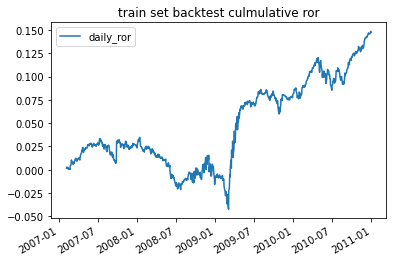

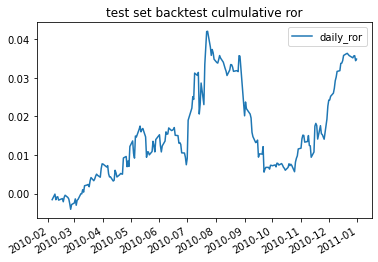

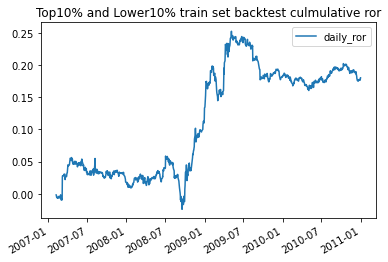

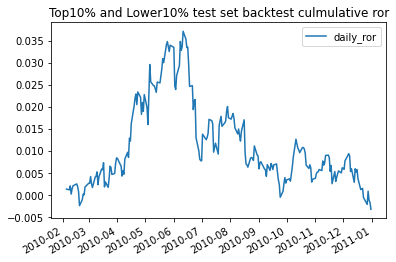

In [7]:
#CNNFactor
#train set
CNNFactor_train_weight_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\CNN_factor_train_weight.csv',index_col=0)
CNNFactor_train_weight_ls_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\CNNFactor_train_top.csv',index_col=0)
#test_set
CNNFactor_test_weight_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\CNN_factor_test_weight.csv',index_col=0)
CNNFactor_test_weight_ls_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\CNNFactor_test_top.csv',index_col=0)

bkt(CNNFactor_train_weight_df,20,'train set backtest culmulative ror')
bkt(CNNFactor_test_weight_df,20,'test set backtest culmulative ror')
bkt(CNNFactor_train_weight_ls_df,1,'Top10% and Lower10% train set backtest culmulative ror',weight_type_str='weight_20')
bkt(CNNFactor_test_weight_ls_df,1,'Top10% and Lower10% test set backtest culmulative ror',weight_type_str='weight_20')

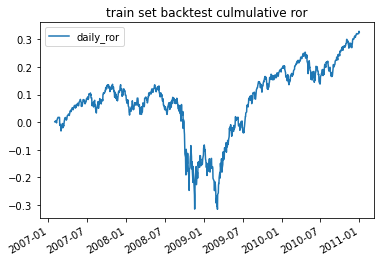

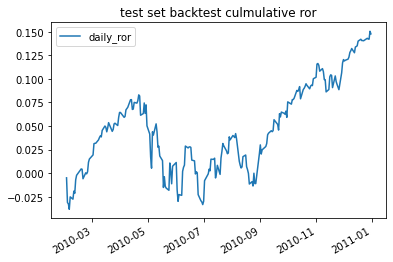

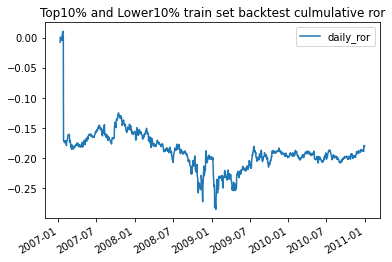

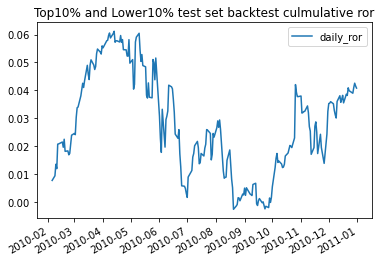

In [19]:
#Lasso Factor
#train set
LassoFactor_train_weight_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\Lasso_factor_train_weight.csv',index_col=0)
LassoFactor_train_weight_ls_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\LassoFactor_train_top.csv',index_col=0)
#test_set
LassoFactor_test_weight_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\Lasso_factor_test_weight.csv',index_col=0)
LassoFactor_test_weight_ls_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\LassoFactor_test_top.csv',index_col=0)
bkt(LassoFactor_train_weight_df,20,'train set backtest culmulative ror')
bkt(LassoFactor_test_weight_df,20,'test set backtest culmulative ror')
bkt(LassoFactor_train_weight_ls_df,1,'Top10% and Lower10% train set backtest culmulative ror',weight_type_str='weight_20')
bkt(LassoFactor_test_weight_ls_df,1,'Top10% and Lower10% test set backtest culmulative ror',weight_type_str='weight_20')

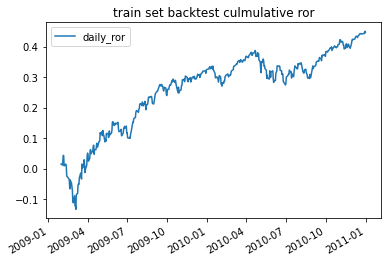

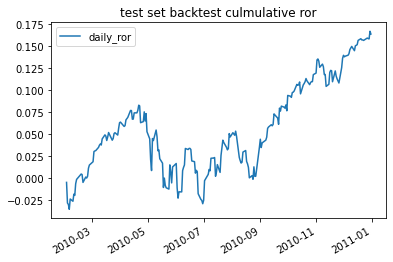

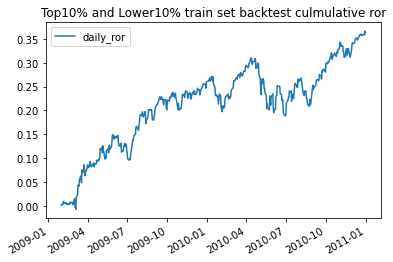

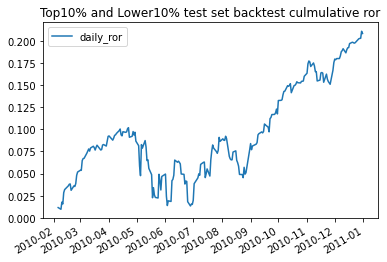

In [8]:
#XGBoost Factor
#train set
XGBoostFactor_train_weight_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\XGBoost_train_20_weight.csv',index_col=0)
XGBoostFactor_train_weight_ls_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\XGBoostFactor_train_top.csv',index_col=0)
#test_set
XGBoostFactor_test_weight_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\XGBoost_test_20_weight.csv',index_col=0)
XGBoostFactor_test_weight_ls_df = pd.read_csv(r'C:\Users\zhuyu\PycharmProjects\ml4fin\weights\XGBoostFactor_test_top.csv',index_col=0)
bkt(XGBoostFactor_train_weight_df,1,'train set backtest culmulative ror',weight_type_str='weight_20')
bkt(XGBoostFactor_test_weight_df,1,'test set backtest culmulative ror',weight_type_str='weight_20')
bkt(XGBoostFactor_train_weight_ls_df,1,'Top10% and Lower10% train set backtest culmulative ror',weight_type_str='weight_mean_20')
bkt(XGBoostFactor_test_weight_ls_df,1,'Top10% and Lower10% test set backtest culmulative ror',weight_type_str='weight_mean_20')

# Conclusion

Basing on above results, factor combined by XGBoost gives us the best factor in the rate of return sense.
The most complex model: Convoluted Neural Network didn't give us a satifying result, which is even worse than Lasso. Due to limited time and computing power, we didn't do much research over ther design of the structure of the network and objective variables. For example, basically we hold each portfolio for 20 days, then it is natural that we should try to train the model to fit the the next 20 days culmulative rate of return, which may give us better performance. Similar refinement idea applies to other two model.
